In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#to bring columns in same scale
#Do data processing than prediction

In [2]:
#load the data
data = pd.read_csv("nifty.csv", date_parser= True)
data.head()

,Date,Open,High,Low,Close,Volume,Turnover
0,2015-01-01,8272.80,8294.70,8248.75,8284.00,56560411,2.321880e+10
1,2015-01-02,8288.70,8410.60,8288.70,8395.45,101887024,4.715720e+10
2,2015-01-05,8407.95,8445.60,8363.90,8378.40,118160545,5.525520e+10
3,2015-01-06,8325.30,8327.85,8111.35,8127.35,172799618,8.089190e+10
4,2015-01-07,8118.65,8151.20,8065.45,8102.10,164075424,7.464330e+10


In [3]:
#date not included to predict target

In [3]:
#training data - 2004 to dec 2018 
#testing - 2019
data_training = data[data['Date'] < '2019-01-01'].copy()

In [4]:
data_training.tail()

,Date,Open,High,Low,Close,Volume,Turnover
984,2018-12-24,10780.90,10782.30,10649.25,10663.50,230291344,1.069560e+11
985,2018-12-26,10635.45,10747.50,10534.55,10729.85,271942701,1.283199e+11
986,2018-12-27,10817.90,10834.20,10764.45,10779.80,470160392,1.911988e+11
987,2018-12-28,10820.95,10893.60,10817.15,10859.90,253086507,1.261501e+11
988,2018-12-31,10913.20,10923.55,10853.20,10862.55,186494657,1.017613e+11


In [5]:
data_test = data[data['Date'] >= '2019-01-01'].copy()
data_test.tail()

,Date,Open,High,Low,Close,Volume,Turnover
1391,2020-08-18,11259.80,11401.70,11253.15,11385.35,579242492,2.726751e+11
1392,2020-08-19,11452.15,11460.35,11394.10,11408.40,626217997,2.752812e+11
1393,2020-08-20,11317.45,11361.45,11289.80,11312.20,791587770,2.767618e+11
1394,2020-08-21,11409.65,11418.50,11362.20,11371.60,668719170,2.629426e+11
1395,2020-08-24,11412.00,11497.25,11410.65,11466.45,532900535,2.892084e+11


In [6]:
training_data = data_training.drop(['Date', 'Turnover'], axis=1)

In [8]:
training_data.head()

,Open,High,Low,Close,Volume
0,8272.80,8294.70,8248.75,8284.00,56560411
1,8288.70,8410.60,8288.70,8395.45,101887024
2,8407.95,8445.60,8363.90,8378.40,118160545
3,8325.30,8327.85,8111.35,8127.35,172799618
4,8118.65,8151.20,8065.45,8102.10,164075424


In [9]:
#we are going to predict open, we will read a set of 60days data
#based on 60 days data predict data of 61th day
scaler = MinMaxScaler()
#scale data between 0 and 1
training_data = scaler.fit_transform(training_data)
training_data.shape


(989, 5)

In [10]:
training_data[0]

array([0.26419424, 0.26671604, 0.29130755, 0.27546719, 0.05513762])

In [11]:
#create training set
X_train = []
y_train = []
training_data.shape[0]

989

In [12]:
#read 1st 60 days data , put it in X_train
#iterate from 60 to 3617
#from day 1 to 59th day in X train, 60th day data in y_train
for i in range(60, training_data.shape[0]):
    X_train.append(training_data[i-60 : i])
    #i starts from 60, range is (0,60)
    #y_train, get the Open 
    y_train.append(training_data[i,0])
    


In [13]:
len(X_train)

929

In [14]:
#convert list into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

In [15]:
X_train.shape
y_train.shape

(929,)

In [16]:
#build LSTM
#first we need to import Keras layers, which we import from tensorflow

from tensorflow.keras import Sequential

#next import from keras layers, dense LTSM and dropout
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [17]:
#create LSTM model, regression (as continous value prediction)

regressor = Sequential()
# add 4 layer of LSTM
regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1],5)))
#units - how many units we want in lstm network
#return seq -  first cell to next cell
#input shape - 
#20% of neurons dropped
regressor.add(Dropout(0.2))
# add another layer of lstm
regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True ))
regressor.add(Dropout(0.2))
# add another layer of lstm
regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True ))
regressor.add(Dropout(0.2))
# add final layer of lstm
regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.2))

#add a final dense layer, single output
regressor.add(Dense(units=1))

In [18]:
#X_train.shape[1],5
#get summary of model
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 60)            15840     
_________________________________________________________________
dropout (Dropout)            (None, 60, 60)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

In [19]:
#compile the model
regressor.compile(optimizer='adam', loss = 'mean_squared_error')

In [20]:
#final stage - train the model
regressor.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
30/30 [==============================] - 8s 260ms/step - loss: 0.0996
Epoch 2/50
30/30 [==============================] - 7s 237ms/step - loss: 0.0096
Epoch 3/50
30/30 [==============================] - 7s 237ms/step - loss: 0.0090
Epoch 4/50
30/30 [==============================] - 7s 232ms/step - loss: 0.0065
Epoch 5/50
30/30 [==============================] - 7s 234ms/step - loss: 0.0054
Epoch 6/50
30/30 [==============================] - 7s 217ms/step - loss: 0.0212
Epoch 7/50
30/30 [==============================] - 6s 211ms/step - loss: 0.0051
Epoch 8/50
30/30 [==============================] - 6s 212ms/step - loss: 0.0048
Epoch 9/50
30/30 [==============================] - 6s 209ms/step - loss: 0.0051
Epoch 10/50
30/30 [==============================] - 6s 209ms/step - loss: 0.0044
Epoch 11/50
30/30 [==============================] - 6s 209ms/step - loss: 0.0051
Epoch 12/50
30/30 [==============================] - 5s 180ms/step - loss: 0.0046
Epoch 13/50
30/30 [======

In [48]:
#do prediction, before that prepare the test dataset
#to predict the data of 1st data we need to have data 
#of previous 60 days
#to do that first get past 60 days of data

past_60_days = data_training.tail(60)
past_60_days

,Date,Open,High,Low,Close,Volume,Turnover
929,2018-10-03,10982.70,10989.05,10843.75,10858.25,398756507,2.122559e+11
930,2018-10-04,10754.70,10754.70,10547.25,10599.25,438202008,2.371157e+11
931,2018-10-05,10514.10,10540.65,10261.90,10316.45,625153832,2.525421e+11
932,2018-10-08,10310.15,10398.35,10198.40,10348.05,470279031,2.213094e+11
933,2018-10-09,10390.30,10397.60,10279.35,10301.05,443795275,1.828541e+11
934,2018-10-10,10331.85,10482.35,10318.25,10460.10,373844130,1.959259e+11
935,2018-10-11,10169.80,10335.95,10138.60,10234.65,498509417,2.190713e+11
936,2018-10-12,10331.55,10492.45,10322.15,10472.50,354056762,1.860604e+11
937,2018-10-15,10524.20,10526.30,10410.15,10512.50,267517728,1.437215e+11
938,2018-10-16,10550.15,10604.90,10525.30,10584.75,273444095,1.545303e+11


In [49]:
#append this data in the test set
df = past_60_days.append(data_test,ignore_index= True)
df = df.drop(['Date', 'Turnover'], axis=1)
df.head()

,Open,High,Low,Close,Volume
0,10982.70,10989.05,10843.75,10858.25,398756507
1,10754.70,10754.70,10547.25,10599.25,438202008
2,10514.10,10540.65,10261.90,10316.45,625153832
3,10310.15,10398.35,10198.40,10348.05,470279031
4,10390.30,10397.60,10279.35,10301.05,443795275


In [50]:
#scale down vales 0 to 1
inputs = scaler.transform(df)
inputs

array([[0.83733596, 0.83682818, 0.82255819, 0.81537994, 0.52743037],
       [0.78911414, 0.7872408 , 0.76185846, 0.76105833, 0.58187233],
       [0.73822743, 0.74194879, 0.70344136, 0.701745  , 0.83989979],
       ...,
       [0.90813532, 0.91562632, 0.91387393, 0.91058957, 1.06960885],
       [0.92763554, 0.92769784, 0.92869572, 0.92304788, 0.90002787],
       [0.92813257, 0.94436098, 0.93861445, 0.94294134, 0.71257349]])

In [51]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60 : i])
    y_test.append(inputs[i, 0])


In [52]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape


(407, 60, 5)

In [53]:
y_test.shape

(407,)

In [54]:
#do prediction 
y_pred = regressor.predict(X_test)

In [55]:
y_pred

array([[0.7348184 ],
       [0.7359692 ],
       [0.73749816],
       [0.738051  ],
       [0.7369976 ],
       [0.73533493],
       [0.7336534 ],
       [0.7323026 ],
       [0.73196733],
       [0.73249257],
       [0.7330206 ],
       [0.73366517],
       [0.7350431 ],
       [0.7372119 ],
       [0.7395759 ],
       [0.7422172 ],
       [0.74473536],
       [0.74653065],
       [0.7467509 ],
       [0.74457055],
       [0.73980325],
       [0.73329103],
       [0.7259448 ],
       [0.71818453],
       [0.71245867],
       [0.71058935],
       [0.7128624 ],
       [0.7187191 ],
       [0.72726524],
       [0.7366878 ],
       [0.74516606],
       [0.7513227 ],
       [0.75426966],
       [0.7514536 ],
       [0.7439211 ],
       [0.7345664 ],
       [0.72549385],
       [0.71846485],
       [0.7147464 ],
       [0.71382034],
       [0.71544695],
       [0.7184903 ],
       [0.72243613],
       [0.724865  ],
       [0.72726923],
       [0.7303229 ],
       [0.73482114],
       [0.740

In [56]:
y_test

array([0.81597454, 0.81325677, 0.79801825, 0.77748168, 0.79972082,
       0.79578694, 0.8118926 , 0.81124753, 0.80604465, 0.80017554,
       0.79394689, 0.81977095, 0.82425473, 0.82298573, 0.82393748,
       0.83037763, 0.82641202, 0.80801159, 0.81133213, 0.79709823,
       0.76775272, 0.778021  , 0.77554646, 0.80955553, 0.81492761,
       0.82167444, 0.83361357, 0.85589501, 0.84596512, 0.8263803 ,
       0.81555154, 0.81361632, 0.79575521, 0.79451794, 0.78571957,
       0.76415723, 0.76812284, 0.78687224, 0.79503611, 0.80149741,
       0.79347102, 0.81586879, 0.81259055, 0.80771549, 0.81241077,
       0.84625065, 0.85748126, 0.84921164, 0.85553546, 0.88992524,
       0.90998594, 0.92189334, 0.92069837, 0.94121379, 0.94680795,
       0.95802798, 0.95715026, 0.92467456, 0.9203494 , 0.95339615,
       0.9390565 , 0.97327707, 0.98168417, 0.99148716, 0.99651026,
       0.98062667, 0.97601599, 0.98996436, 0.97044299, 0.97780316,
       0.96631875, 0.97061218, 0.98206487, 0.99670061, 1.02206

In [63]:
#bring values back to normal scale, 
#divide y_test and y_pred by this scale
scaler.scale_

array([2.11499212e-04, 2.11595430e-04, 2.04720863e-04, 2.09735942e-04,
       1.38018160e-09])

In [58]:
scale = 1/2.11499212e-04
scale

4728.150003698359

In [59]:
#so 1st col was divided by 1221.59 to get the value between 0 and 1
y_pred = y_pred * scale
y_test = y_test * scale

In [61]:
y_pred

array([[3474.3315 ],
       [3479.7727 ],
       [3487.002  ],
       [3489.6157 ],
       [3484.6353 ],
       [3476.7737 ],
       [3468.8235 ],
       [3462.4365 ],
       [3460.8513 ],
       [3463.3347 ],
       [3465.8313 ],
       [3468.879  ],
       [3475.394  ],
       [3485.6482 ],
       [3496.826  ],
       [3509.3142 ],
       [3521.2205 ],
       [3529.7087 ],
       [3530.7502 ],
       [3520.4412 ],
       [3497.9006 ],
       [3467.1099 ],
       [3432.376  ],
       [3395.684  ],
       [3368.6113 ],
       [3359.773  ],
       [3370.5203 ],
       [3398.2117 ],
       [3438.6191 ],
       [3483.1702 ],
       [3523.2568 ],
       [3552.3662 ],
       [3566.3    ],
       [3552.985  ],
       [3517.3704 ],
       [3473.14   ],
       [3430.2437 ],
       [3397.0095 ],
       [3379.4282 ],
       [3375.0496 ],
       [3382.7405 ],
       [3397.13   ],
       [3415.7864 ],
       [3427.2705 ],
       [3438.638  ],
       [3453.0762 ],
       [3474.3445 ],
       [3503.

In [60]:
y_test

array([3858.05000302, 3845.20000301, 3773.15000295, 3676.05000288,
       3781.20000296, 3762.60000294, 3838.750003  , 3835.700003  ,
       3811.10000298, 3783.35000296, 3753.90000294, 3876.00000303,
       3897.20000305, 3891.20000304, 3895.70000305, 3926.15000307,
       3907.40000306, 3820.40000299, 3836.100003  , 3768.80000295,
       3630.05000284, 3678.60000288, 3666.90000287, 3827.70000299,
       3853.10000301, 3885.00000304, 3941.45000308, 4046.80000317,
       3999.85000313, 3907.25000306, 3856.05000302, 3846.90000301,
       3762.45000294, 3756.60000294, 3715.00000291, 3613.05000283,
       3631.80000284, 3720.45000291, 3759.05000294, 3789.60000296,
       3751.65000293, 3857.55000302, 3842.05000301, 3819.00000299,
       3841.200003  , 4001.20000313, 4054.30000317, 4015.20000314,
       4045.10000316, 4207.70000329, 4302.55000337, 4358.85000341,
       4353.20000341, 4450.20000348, 4476.6500035 , 4529.70000354,
       4525.55000354, 4372.00000342, 4351.5500034 , 4507.80000

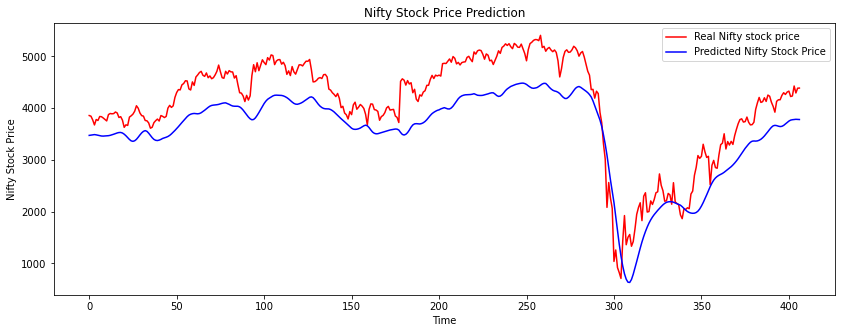

In [62]:
###Visualization 
#Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = "Real Nifty stock price")
plt.plot(y_pred, color = 'blue', label = "Predicted Nifty Stock Price")
plt.title("Nifty Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Nifty Stock Price")
plt.legend()
plt.show()

In [ ]:
#we can see the not tht precise, we can change in the model,
#increase epochs , modify units and run to get low loss, 
#low loss means better accuracy 